#### Imports 

In [4]:
pip install config


Note: you may need to restart the kernel to use updated packages.


In [2]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.oauth2 as oauth2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import json
from tqdm import tqdm
import spotipy.util as util
from sklearn.preprocessing import Normalizer, MinMaxScaler


#### API START

In [10]:
import config

In [11]:

credentials = SpotifyClientCredentials(
        client_id=config.client_id,
        client_secret=config.client_secret)
sp = spotipy.Spotify(client_credentials_manager=credentials)

In [12]:
genre_choice= ['EDM', 'Hip-Hop/Rap', 'K-Pop', 'Latin', 'Metal', 'Pop', 'R&B', 'Reggae', 'Rock', 'Blues', 'Classical', 'Country']

#### API CALLS

In [13]:
def get_genre(genre_list ):

    all_genre = {}
    for genre in tqdm(genre_list):
        song_id = []
        offset = 0
        res = sp.search(q = genre, offset=offset,type='track', limit=50)
        while res:
            idx = 0
            try:
                while idx < len(res['tracks']['items']):
                    song_id.append(res['tracks']['items'][idx]['id'])
                   
                    idx +=1
                offset += 50
                res = sp.search(q = genre, offset=offset,type='track', limit=50)
            except:
                break
        all_genre[genre] = song_id
    return all_genre

In [14]:
def get_name(genre_list):
    all_name= {}
    for genre in tqdm(genre_list):
        items = []
        offset = 0
        res = sp.search(q = genre, offset=offset,type='track', limit=50)
        while res:
            idx = 0
            try:
                while idx < len(res['tracks']['items']):
                    items.append(res['tracks']['items'][idx]['name'])
                    idx +=1
                offset += 50
                res = sp.search(q = genre, offset=offset,type='track', limit=50)
            except:
                break
        all_name[genre] = items
    return all_name


In [15]:
def get_popular(genre_list):
    all_popular= {}
    for genre in tqdm(genre_list):
        popular = []
        offset = 0
        res = sp.search(q = genre, offset=offset,type='track', limit=50)
        while res:
            idx = 0
            try:
                while idx < len(res['tracks']['items']):
                    popular.append(res['tracks']['items'][idx]['popularity'])
                    idx +=1
                offset += 50
                res = sp.search(q = genre, offset=offset,type='track', limit=50)
            except:
                break
        all_popular[genre] = popular
    return all_popular

In [16]:
song_list = get_genre(genre_choice)

100%|██████████| 12/12 [02:10<00:00, 10.91s/it]


In [17]:
## make the respone from the API CALL into a dataframe 
result = []            
for genre,list_of_id in song_list.items():
    for i in list_of_id:
        result.append([genre,i])
        
genre_df = pd.DataFrame(result, columns= ["genre","id"])

In [18]:
name_list = get_name(genre_choice)

100%|██████████| 12/12 [01:59<00:00,  9.96s/it]


In [19]:
## make the respone from the API CALL into a dataframe 
result_1 = []
for genre,list_of_name in name_list.items():
    for i in list_of_name:
        result_1.append([genre,i])
        
name_df = pd.DataFrame(result_1, columns= ["genre","name"])

In [20]:
pop_1 = get_popular(genre_choice)

100%|██████████| 12/12 [02:00<00:00, 10.06s/it]


In [21]:
result_pop = []
for genre,list_of_pop in pop_1.items():
    for i in list_of_pop:
        result_pop.append([genre,i])
        
pop_df = pd.DataFrame(result_pop, columns= ["genre","popularity"])

In [22]:
song_name = name_df.name 

In [23]:
song_pop = pop_df.popularity

In [24]:
genre_df['name'] = song_name

In [25]:
genre_df['popularity'] = song_pop

In [26]:
## make the song_ids into a numpy list so that we can make another API call for the song features.
final_ids = np.ravel(list(song_list.values()))  

In [27]:
## get the song features for all the song_ids in the final_ids list 
song_feature_test = [] 
for i in tqdm(range(0,len(final_ids),50)):
    song_feature_test.append(sp.audio_features(final_ids[i:i+50]))

 73%|███████▎  | 350/480 [00:49<00:10, 12.00it/s]

retrying after...1secs


100%|██████████| 480/480 [01:04<00:00,  7.40it/s]


In [28]:
## loop through the respone and append the needed features while checking for NoNtypes
items_1 = []
# c = 0 
# try:
for i in song_feature_test:
    for j in i:
        
        if j != dict:
            items_1.append(j)
        else:
            items_1.append([j['danceability'],j['energy'],j['key'],j['loudness'],\
                    j['mode'],j['speechiness'],j['acousticness'],j['instrumentalness'],\
                    j['liveness'],j['valence'],j['tempo'],j['type'],j['id'],j['uri'],\
                    j['track_href'],j['analysis_url'],j['duration_ms'],j['time_signature']])


In [29]:
## get rid of the NonTypes
items_1 =[x for x in items_1 if x is not None]

In [30]:
## make a dataframe with the features of the song_ids
final_df1 = pd.DataFrame(items_1, columns= list(song_feature_test[0][0].keys()))

In [31]:
## check for any duplicates 
final_df1= final_df1.drop_duplicates(subset = 'id')

In [32]:
## check for any duplicates in the genre dataframe
genre_df.id.duplicated().any()

True

In [33]:
genre_df= genre_df.drop_duplicates(subset = 'id')

In [34]:
## get the final data frame with all the needed features
merged_df = pd.merge(final_df1,genre_df, on= 'id')

In [35]:
merged_df 

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,name,popularity
0,0.805,0.895,1,-3.527,1,0.1090,0.00159,0.124000,0.4400,0.196,...,audio_features,3MckdkpumOZiX2efM3B266,spotify:track:3MckdkpumOZiX2efM3B266,https://api.spotify.com/v1/tracks/3MckdkpumOZi...,https://api.spotify.com/v1/audio-analysis/3Mck...,148571,4,EDM,EDM O' CLOCK,48
1,0.630,0.839,6,-3.971,0,0.0422,0.03130,0.537000,0.1220,0.624,...,audio_features,5wlscxWc7OyrsE22xToo1N,spotify:track:5wlscxWc7OyrsE22xToo1N,https://api.spotify.com/v1/tracks/5wlscxWc7Oyr...,https://api.spotify.com/v1/audio-analysis/5wls...,142503,4,EDM,EDM Bubble,56
2,0.661,0.809,8,-10.563,1,0.2980,0.00038,0.244000,0.3450,0.512,...,audio_features,6eT1v3qX8tg5ePguuAZ8gM,spotify:track:6eT1v3qX8tg5ePguuAZ8gM,https://api.spotify.com/v1/tracks/6eT1v3qX8tg5...,https://api.spotify.com/v1/audio-analysis/6eT1...,198732,4,EDM,Edm Romance,36
3,0.607,0.631,6,-7.753,0,0.1710,0.41000,0.000000,0.1000,0.335,...,audio_features,16Fz1NtxjEaWdZZkZU8nJ3,spotify:track:16Fz1NtxjEaWdZZkZU8nJ3,https://api.spotify.com/v1/tracks/16Fz1NtxjEaW...,https://api.spotify.com/v1/audio-analysis/16Fz...,186000,4,EDM,Edmore,37
4,0.501,0.788,10,-3.655,0,0.1340,0.01960,0.001140,0.0983,0.377,...,audio_features,2jVx2ayLTAaRGz7pwY7j9I,spotify:track:2jVx2ayLTAaRGz7pwY7j9I,https://api.spotify.com/v1/tracks/2jVx2ayLTAaR...,https://api.spotify.com/v1/audio-analysis/2jVx...,189600,4,EDM,EDM Sucks,46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23205,0.763,0.693,1,-5.762,1,0.1440,0.16400,0.783000,0.1110,0.582,...,audio_features,67fMPkQFzcoCquj3ehdOlZ,spotify:track:67fMPkQFzcoCquj3ehdOlZ,https://api.spotify.com/v1/tracks/67fMPkQFzcoC...,https://api.spotify.com/v1/audio-analysis/67fM...,162864,4,Country,Stunning Woman,32
23206,0.716,0.617,1,-9.882,0,0.2660,0.03090,0.000000,0.0699,0.664,...,audio_features,0MPJIyKMHlgjnfkkIXTzHp,spotify:track:0MPJIyKMHlgjnfkkIXTzHp,https://api.spotify.com/v1/tracks/0MPJIyKMHlgj...,https://api.spotify.com/v1/audio-analysis/0MPJ...,137665,4,Country,Duties,32
23207,0.471,0.839,2,-6.335,1,0.0542,0.00548,0.001120,0.2040,0.279,...,audio_features,0UMHSZ9HuMNBKnqVzS3Fre,spotify:track:0UMHSZ9HuMNBKnqVzS3Fre,https://api.spotify.com/v1/tracks/0UMHSZ9HuMNB...,https://api.spotify.com/v1/audio-analysis/0UMH...,292347,4,Country,Goin' to the Country,19
23208,0.506,0.942,5,-4.183,1,0.0330,0.04490,0.159000,0.0876,0.931,...,audio_features,28hAbUS1ml3FK4fOyshS99,spotify:track:28hAbUS1ml3FK4fOyshS99,https://api.spotify.com/v1/tracks/28hAbUS1ml3F...,https://api.spotify.com/v1/audio-analysis/28hA...,199573,4,Country,Boogie Woogie Country Girl,30


#### EDA

In [3]:
merged_df = pd.read_csv('working_df.csv')

In [8]:
merged_df.drop('Unnamed: 0', axis=1, inplace= True)

In [9]:
merged_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,name,popularity
0,0.805,0.895,1,-3.527,1,0.1090,0.001590,0.124000,0.4400,0.196,...,audio_features,3MckdkpumOZiX2efM3B266,spotify:track:3MckdkpumOZiX2efM3B266,https://api.spotify.com/v1/tracks/3MckdkpumOZi...,https://api.spotify.com/v1/audio-analysis/3Mck...,148571,4,EDM,EDM O' CLOCK,48
1,0.630,0.839,6,-3.971,0,0.0422,0.031300,0.537000,0.1220,0.624,...,audio_features,5wlscxWc7OyrsE22xToo1N,spotify:track:5wlscxWc7OyrsE22xToo1N,https://api.spotify.com/v1/tracks/5wlscxWc7Oyr...,https://api.spotify.com/v1/audio-analysis/5wls...,142503,4,EDM,EDM Bubble,56
2,0.607,0.631,6,-7.753,0,0.1710,0.410000,0.000000,0.1000,0.335,...,audio_features,16Fz1NtxjEaWdZZkZU8nJ3,spotify:track:16Fz1NtxjEaWdZZkZU8nJ3,https://api.spotify.com/v1/tracks/16Fz1NtxjEaW...,https://api.spotify.com/v1/audio-analysis/16Fz...,186000,4,EDM,Edmore,37
3,0.501,0.788,10,-3.655,0,0.1340,0.019600,0.001140,0.0983,0.377,...,audio_features,2jVx2ayLTAaRGz7pwY7j9I,spotify:track:2jVx2ayLTAaRGz7pwY7j9I,https://api.spotify.com/v1/tracks/2jVx2ayLTAaR...,https://api.spotify.com/v1/audio-analysis/2jVx...,189600,4,EDM,EDM Sucks,45
4,0.661,0.950,9,-3.417,1,0.1310,0.000802,0.452000,0.1160,0.301,...,audio_features,6iBzUjscIAeQ2vKV67UuZM,spotify:track:6iBzUjscIAeQ2vKV67UuZM,https://api.spotify.com/v1/tracks/6iBzUjscIAeQ...,https://api.spotify.com/v1/audio-analysis/6iBz...,263088,4,EDM,EDM Death Machine,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22722,0.433,0.898,2,-6.846,1,0.0812,0.073100,0.000000,0.3730,0.456,...,audio_features,7f8EklpoN6clFk1IOSLGHt,spotify:track:7f8EklpoN6clFk1IOSLGHt,https://api.spotify.com/v1/tracks/7f8EklpoN6cl...,https://api.spotify.com/v1/audio-analysis/7f8E...,190453,4,Country,Going up the Country,22
22723,0.469,0.648,0,-6.020,1,0.0311,0.090100,0.000073,0.2040,0.761,...,audio_features,12Dtv2yJsXqSv7buGB5atX,spotify:track:12Dtv2yJsXqSv7buGB5atX,https://api.spotify.com/v1/tracks/12Dtv2yJsXqS...,https://api.spotify.com/v1/audio-analysis/12Dt...,274333,4,Country,Man Of Steel,26
22724,0.676,0.791,8,-5.640,1,0.0383,0.290000,0.000000,0.4870,0.944,...,audio_features,06s2xqfSDROCIhzxH5Hsu6,spotify:track:06s2xqfSDROCIhzxH5Hsu6,https://api.spotify.com/v1/tracks/06s2xqfSDROC...,https://api.spotify.com/v1/audio-analysis/06s2...,233973,4,Country,Top Of The World,26
22725,0.545,0.723,9,-5.189,0,0.0284,0.063300,0.000000,0.3300,0.551,...,audio_features,3JMyRsMQIeRXSWwFbO5gLn,spotify:track:3JMyRsMQIeRXSWwFbO5gLn,https://api.spotify.com/v1/tracks/3JMyRsMQIeRX...,https://api.spotify.com/v1/audio-analysis/3JMy...,228965,4,Country,Kiss You There,24


##### Outliers

Text(0.5, 1, 'Popularity vs. Energy')

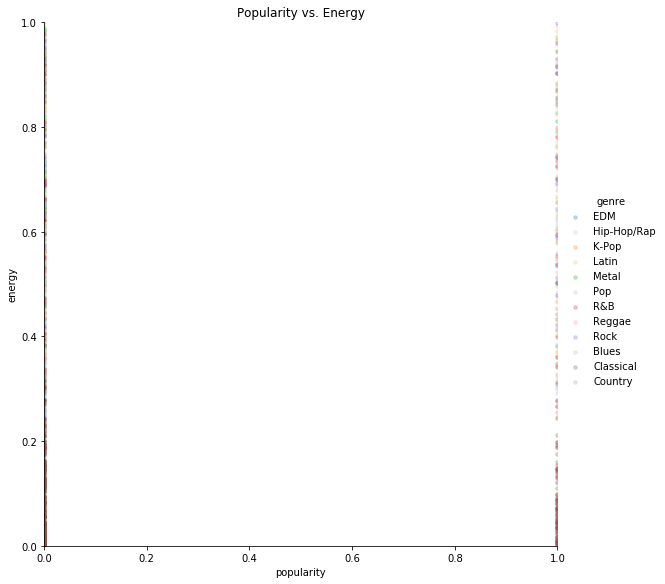

In [10]:

sns.lmplot(data=merged_df, x="acousticness", y="energy", hue="genre", palette="tab20",
           fit_reg=False, legend=True, height=8, 
          scatter_kws={'alpha':0.25, 's':12})
plt.xlim(0,1.0)
plt.ylim(0,1.0)
plt.title("Popularity vs. Energy")